# Quantify isolation of Baffin Bay interior from Atlantic Water

In [1]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
from mpl_toolkits.basemap import Basemap, cm
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, TransformedBbox, BboxPatch, BboxConnector 
from matplotlib.transforms import Bbox
import cmocean
import pickle
import matplotlib
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.colors import ListedColormap
from math import sin, cos, sqrt, atan2, radians
import xarray as xr
import glob

%matplotlib inline

#### Parameters:

In [2]:
# domain dimensions:
jmin, jmax = 159, 799
imin, imax = 1139, 2179

# Resolution of grid cells to show in figure:
grid_reso  = 10

# Colors:
land_color  = '#a9a7a2'
land_outline_color = '#373736'
color_GS = '#003856';
color_BB = '#0369a0';
color_BI = '#81b4cf';

# transect coordinates:
BB_coords = (1470,1471,515,670) # Baffin Bay
# DS_coords = (1320,1321,538,630) # Davis Strait (jet)
DS_coords = (1290,1291,502,630) # Davis Strait (jet)

years = [2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, \
         2017, 2018, 2019]

month_list = ['Jan.','Feb.','Mar.','Apr.','May','June','July', 'Aug.', 'Sep.','Oct.','Nov.', 'Dec.']

#### Load files:

In [3]:
# Modified ANHA12 mesh mask file (http://knossos.eas.ualberta.ca/anha/anhatable.php)
mfile        = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mask_Pb-20230213.nc')
mesh_lon     = mfile['nav_lon'].values
mesh_lat     = mfile['nav_lat'].values
mask         = mfile['tmask'].values[0]
mesh_bathy   = mfile['tmask'].values[0,:,:,:]
bathy_masked = np.ma.masked_where((mesh_bathy> 0.1), mesh_bathy)
mesh_depth   = mfile['nav_lev'].values

# General file:
mesh  = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
hdept = mesh['hdept'].values[0,:,:]

In [4]:
# transect coordinates
DS_lons  = mesh_lon[DS_coords[0]:DS_coords[1],DS_coords[2]:DS_coords[3]][0,:]
DS_lats  = mesh_lat[DS_coords[0]:DS_coords[1],DS_coords[2]:DS_coords[3]][0,:]
DS_deps  = bathy_masked[:,DS_coords[0]:DS_coords[1],DS_coords[2]:DS_coords[3]][:,0,:]
# DS_depsV = bathy_maskedV[:,DS_coords[0]:DS_coords[1],DS_coords[2]:DS_coords[3]][:,0,:]

#### Calculations

In [8]:
folder1 = f'/data/brogalla/run_storage/Pb-reference-202303/'
comp1   = xr.open_dataset(f'{folder1}climatology-2007-onwards.nc')
comp2   = xr.open_dataset(f'{folder1}climatology-LS-2007-onwards.nc')
dPb_ref = comp1['dissolpb'].values[:,0,:,:,:]
dPb_LS  = comp2['dissolpb'].values[:,0,:,:,:]

In [9]:
delta_dPb         = (dPb_LS - dPb_ref).mean(axis=0) # initially look at mean over full time series, not monthly
delta_dPb_monthly = (dPb_LS - dPb_ref)

In [10]:
# Create masks to isolate Baffin Bay interior and shelf regions

# --- Baffin Bay interior ---
BB_mask  = np.zeros(bathy_masked.shape)
BB_mask[:,imin+10:imax-10,jmin+10:jmax-20] = 1 # excluding the regions of boundary conditions
for depth in range(0,50):
    BB_mask[depth][mesh_lon < -75]   = 0
    BB_mask[depth][hdept < 1000]     = 0 # isolate by depth=1000 m
    BB_mask[depth][mesh_lat <= 66]   = 0
    BB_mask[depth][mesh_lat > 75]    = 0

BB_mask[mesh_bathy < 0.1] = 0

# --- Baffin Island Shelf ---
BI_mask  = np.zeros(bathy_masked.shape)
BI_mask[:,imin+10:imax-10,jmin+10:jmax-20] = 1 # excluding the regions of boundary conditions
for depth in range(0,50):
    BI_mask[depth][mesh_lon < -79]   = 0
    BI_mask[depth][mesh_lon > -40]   = 0
    BI_mask[depth][hdept >= 1000]    = 0 # isolate by depth=1000 m
    BI_mask[depth][mesh_lat <= 67]   = 0
    BI_mask[depth][mesh_lat > 73.5]  = 0
    BI_mask[depth][(mesh_lat < 71) & (mesh_lon < -71)]  = 0

    BI_mask[depth][(mesh_lat > 67)   & (mesh_lat < 77) & (mesh_lon > -59.5)]  = 0
    BI_mask[depth][(mesh_lat > 67.4) & (mesh_lat < 72) & (mesh_lon > -60)]  = 0
    BI_mask[depth][(mesh_lat > 68.4) & (mesh_lat < 77) & (mesh_lon > -62)]  = 0
    BI_mask[depth][(mesh_lat > 70)   & (mesh_lat < 77) & (mesh_lon > -65)]  = 0
    BI_mask[depth][(mesh_lat > 73)   & (mesh_lat < 77) & (mesh_lon > -71)]  = 0

BI_mask[mesh_bathy < 0.1] = 0

# --- West Greenland Shelf ---
WG_mask  = np.zeros(bathy_masked.shape)
WG_mask[:,imin+10:imax-10,jmin+10:jmax-20] = 1 # excluding the regions of boundary conditions
for depth in range(0,50):
    WG_mask[depth][mesh_lon < -69]   = 0
    WG_mask[depth][hdept >= 1000]    = 0 # isolate by depth=1000 m
    WG_mask[depth][mesh_lat <= 67]   = 0
    WG_mask[depth][mesh_lat > 77]    = 0
    WG_mask[depth][(mesh_lat > 64)  & (mesh_lat < 69) & (mesh_lon < -59.8)] = 0
    WG_mask[depth][(mesh_lat > 67)  & (mesh_lat < 73) & (mesh_lon < -64)]   = 0

WG_mask[mesh_bathy < 0.1] = 0

In [11]:
interior_Atl = np.ma.masked_where(BB_mask[:,imin:imax,jmin:jmax]==0, delta_dPb).mean(axis=(1,2))
Baffin_Atl   = np.ma.masked_where(BI_mask[:,imin:imax,jmin:jmax]==0, delta_dPb).mean(axis=(1,2))
WestGr_Atl   = np.ma.masked_where(WG_mask[:,imin:imax,jmin:jmax]==0, delta_dPb).mean(axis=(1,2))

In [12]:
interior_dPb = np.ma.masked_where(BB_mask[:,imin:imax,jmin:jmax]==0, dPb_ref.mean(axis=0)).mean(axis=(1,2))
Baffin_dPb   = np.ma.masked_where(BI_mask[:,imin:imax,jmin:jmax]==0, dPb_ref.mean(axis=0)).mean(axis=(1,2))
WestGr_dPb   = np.ma.masked_where(WG_mask[:,imin:imax,jmin:jmax]==0, dPb_ref.mean(axis=0)).mean(axis=(1,2))

In [13]:
monthly_BB_mask = np.tile(BB_mask[:,imin:imax,jmin:jmax], (12,1,1,1))
monthly_BI_mask = np.tile(BI_mask[:,imin:imax,jmin:jmax], (12,1,1,1))
monthly_WG_mask = np.tile(WG_mask[:,imin:imax,jmin:jmax], (12,1,1,1))

interior_Atl_monthly = np.ma.masked_where(monthly_BB_mask==0, delta_dPb_monthly).mean(axis=(2,3))
Baffin_Atl_monthly   = np.ma.masked_where(monthly_BI_mask==0, delta_dPb_monthly).mean(axis=(2,3))
WestGr_Atl_monthly   = np.ma.masked_where(monthly_WG_mask==0, delta_dPb_monthly).mean(axis=(2,3))

#### Figure:

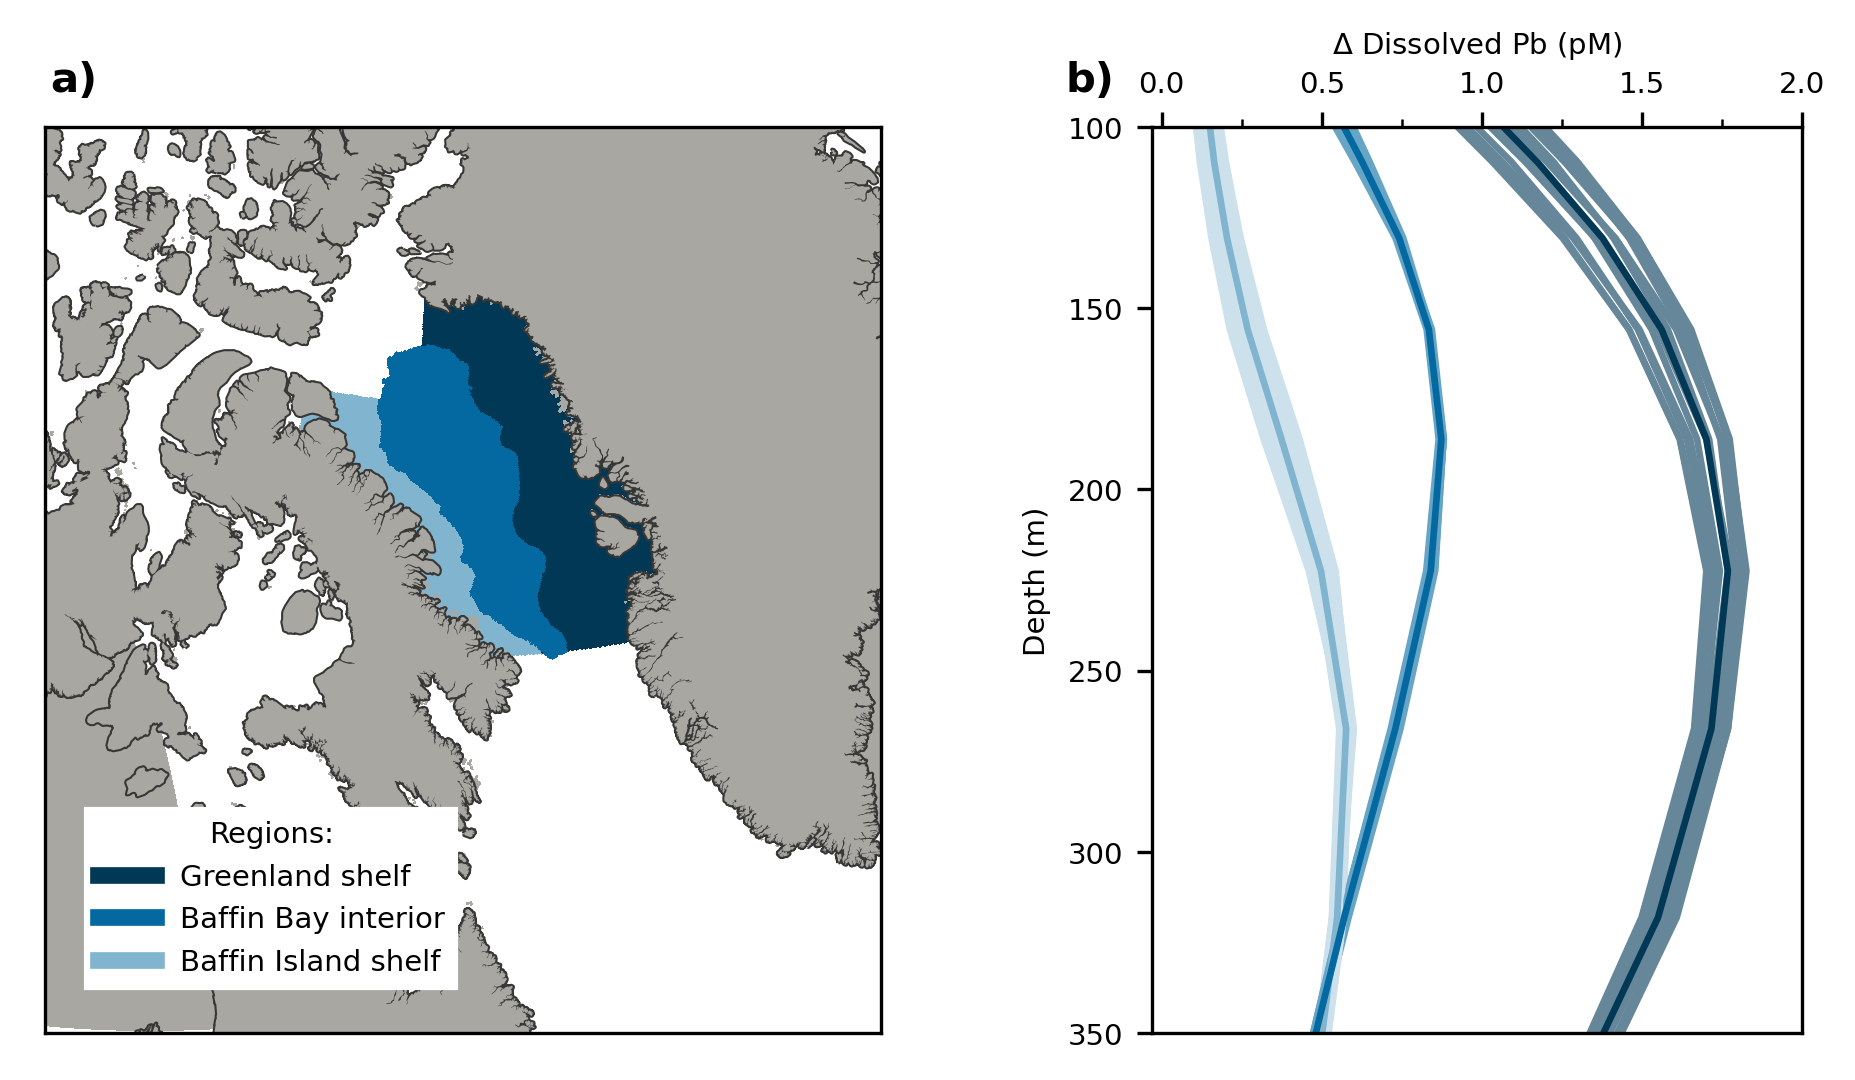

In [97]:
fig, ax = plt.subplots(1,2, figsize=(8, 4), dpi=300, gridspec_kw={'width_ratios': [1.6, 1]})

#------- map --------------------------
proj1=Basemap(projection='eqdc',lat_0 = 69, lon_0 = -65, resolution='i', width=2.4e6, height=2.6e6, ax=ax[0])
proj1.drawcoastlines(color=land_outline_color, linewidth=1.0);
proj1.fillcontinents(color=land_color, lake_color=land_color, zorder=2);
layer=0
x, y = proj1(mesh_lon[imin:imax,jmin:jmax], mesh_lat[imin:imax,jmin:jmax]) 
WG_mask_plot = np.ma.masked_where(WG_mask < 1, WG_mask)
BB_mask_plot = np.ma.masked_where(BB_mask < 1, BB_mask)
BI_mask_plot = np.ma.masked_where(BI_mask < 1, BI_mask)
proj1.pcolormesh(x, y, BI_mask_plot[layer,imin:imax,jmin:jmax] , cmap=ListedColormap([color_BI]))
proj1.pcolormesh(x, y, WG_mask_plot[layer,imin:imax,jmin:jmax], cmap=ListedColormap([color_GS]))
proj1.pcolormesh(x, y, BB_mask_plot[layer,imin:imax,jmin:jmax] , cmap=ListedColormap([color_BB]))
proj1.pcolormesh(x, y, bathy_masked[layer,imin:imax,jmin:jmax], cmap=matplotlib.colors.ListedColormap([land_color]), ax=ax[0])
ax[0].plot([0,0], [0,0], c=color_GS, lw=4, label='Greenland shelf')
ax[0].plot([0,0], [0,0], c=color_BB, lw=4, label='Baffin Bay interior') 
ax[0].plot([0,0], [0,0], c=color_BI, lw=4, label='Baffin Island shelf')

leg = ax[0].legend(loc=(0.05, 0.05), fontsize=7, facecolor='white', fancybox=False, framealpha=1, edgecolor='white')
leg.set_title('Regions:', prop={'size':7})

# ------- profile ----------------------
for month in range(0,12):
    ax[1].plot(WestGr_Atl_monthly[month]*1e12, mesh_depth, c='#668799', lw=1.6)
    ax[1].plot(Baffin_Atl_monthly[month]*1e12, mesh_depth, c='#cce1eb', lw=1.6)
    ax[1].plot(interior_Atl_monthly[month]*1e12, mesh_depth, c='#67a5c6', lw=1.6)
    
ax[1].plot(WestGr_Atl*1e12, mesh_depth, '-', c=color_GS, lw=1.6)
ax[1].plot(Baffin_Atl*1e12, mesh_depth, '-', c=color_BI, lw=1.6)
ax[1].plot(interior_Atl*1e12, mesh_depth, '-', c=color_BB, lw=1.6)
    
ax[1].yaxis.set_minor_locator(MultipleLocator(100))
ax[1].xaxis.set_minor_locator(MultipleLocator(0.25))
ax[1].set_ylim(350,100)
ax[1].set_xlim(-0.03,2.0)
ax[1].xaxis.tick_top()
ax[1].xaxis.set_label_position('top') 
ax[1].set_ylabel('Depth (m)', fontsize=7)
ax[1].tick_params(axis='both', labelsize=7)
ax[1].set_xlabel(r'$\Delta$ Dissolved Pb (pM)', fontsize=7)

fig.text(0.170, 0.91, 'a)', fontsize=10, weight='bold');
fig.text(0.593, 0.91, 'b)', fontsize=10, weight='bold');

# fig.savefig('/ocean/brogalla/GEOTRACES/figures/Pb/R6-BB-isolation.jpg', dpi=300, bbox_inches='tight')